## Data Preprocess

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from deepsramp import *

In [2]:
from joblib import Parallel, delayed
import random

def task_transform(name, position=0):
    idf = df
    indf = ndf
    
    tdf = []
    for _, i in tqdm(idf.iterrows(), total=idf.shape[0], position=position):
        exist_grp = set()

        pospos = list(utils.notnaor(i[name], []))
        negpos = list(utils.notnaor(i[f'{name}_neg'], []))

        for pos, label in [(pospos, 1), (negpos, 0)]:
            for j in pos:
                genome_pos = get_genome_pos(j, i)
                if i[0] + i[6] + str(genome_pos) in exist_grp: continue
                else: exist_grp.add(i[0] + i[6] + str(genome_pos))
                for trans, k in indf.loc[i.id].iterrows():
                    mature_pos = get_mature_pos(genome_pos, k)
                    if mature_pos != -1:
                        tdf += [(i.id, trans, mature_pos, i[0] + i[6] + str(genome_pos), label)]

    tdf = pd.DataFrame(tdf, columns=['id', 'trans', 'pos', 'grp', 'label'])
    tdf = tdf.merge(indf.reset_index(), left_on=['id', 'trans'], right_on=['id', 'trans'])

    return name, tdf

def task_atlas(m6adf):
    tqdm.pandas()
    m6adf['pos'] = m6adf.progress_apply(lambda x: [
        [
            gene, 
            trans, 
            (lambda y: y if y != -1 and len(re.findall(RRACH_PAT, i.seq[y-2:y+3])) else -1)(get_mature_pos(x['start'], i)),
            # x['seqnames'] + x['strand'] + str(x['start'])
            i.length # for max length
        ] for (gene, trans), i in get_trans(x['seqnames'], x['strand'], x['start'], ndf).iterrows()
    ], axis=1)
    m6adf['pos'] = m6adf.pos.apply(lambda x: [i for i in x if i[2] != -1]) # drop -1
    m6adf['pos'] = m6adf.pos.apply(lambda x: [max(x, key=lambda y: y[-1])[:-1]] if x else []) # keep max length
    return m6adf

def get_m6a_neg_ratio4(osdf, label='m6a_pos', test_ratio=10, pat=RRACH_PAT):
    sdf = osdf
    
    sdf['_test_len'] = (sdf[label].apply(lambda x: len(utils.notnaor(x, []))) * test_ratio).apply(round)
    sdf['_neg'] = sdf.apply(lambda x: (random.choices(list(x.m6a_neg), k=x._test_len)) if len(x.m6a_neg) else [], axis=1)
    sdf[f'{label}_neg'] = sdf.apply(lambda x: set(x._neg[:x._test_len]), axis=1)
    
    return sdf

def atlas(m6adf, file):
    m6adf['start'] -= 1
    m6adf['seqnames'] = m6adf['seqnames'].str.slice(3).replace({'M': 'MT'})
    
    npar = 40
    nperpar = m6adf.shape[0] // npar + 1
    m6adf = Parallel(n_jobs=npar)(delayed(task_atlas)(m6adf.iloc[i*nperpar:(i+1)*nperpar]) for i in range(npar))
    m6adf = pd.concat(m6adf)
        
    m6adf['Cell_Line'] = m6adf.Cell_Line.apply(lambda x: list(map(lambda y: y.strip(), x.split(';'))))
    m6adf = m6adf.explode('Cell_Line')
    
    ress = []
    for cl, i in tqdm(m6adf.groupby(['Cell_Line', 'Technique'])):
        cl = ('_'.join(cl))
        # if cl not in ['A549_m6A-CLIP-seq', 'CD8T_m6A-CLIP-seq', 'HEK293T_miCLIP ', 'MOLM13_miCLIP ']: continue
        res = pd.DataFrame(sum(i.pos, []), columns=ndf.index.names+[cl])
        res = res[res[cl] != -1]
        res = res.groupby(ndf.index.names).agg(lambda x: set(x))
        ress += [res]
    
    res = pd.concat(ress, axis=1)
    res['m6a_pos'] = res.apply(lambda x: set(sum([list(i) for i in x if i==i], [])), axis=1)
    res = pd.concat([ndf, res], axis=1)
    res = res.dropna(subset=['m6a_pos'])
    res = get_m6a_neg(res)
    
    cls = res.columns[9:-2].tolist()
    df = res.reset_index().set_index('trans')
    
    for i in tqdm(cls):
        df = get_m6a_neg_ratio4(df, label=i, test_ratio=10)
    
    utils.save([df, cls], file)

## Human

In [2]:
%%time
gtf = read_gtf('data/Homo_sapiens.GRCh38.79.gtf.gz')
seqs = read_seq('data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51662809it [02:16, 379253.73it/s]

CPU times: user 1min 41s, sys: 1min 18s, total: 2min 59s
Wall time: 2min 58s


In [3]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 14.8 s, sys: 746 ms, total: 15.6 s
Wall time: 15.6 s


In [ ]:
# atlas2 human
m6adf = pd.concat([
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Human_Site_last7method.txt', sep='\t'), 
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Human_Site_top5Method.txt', sep='\t')
])
atlas(m6adf, 'data/m6aatlas/atlas2_human.data')


## Mouse

In [98]:
%%time
gtf = read_gtf('data/Mus_musculus.GRCm38.102.gtf.gz')
seqs = read_seq('data/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:29: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
45514629it [01:35, 477199.85it/s]


CPU times: user 1min 27s, sys: 41.6 s, total: 2min 9s
Wall time: 2min 8s


In [99]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 11 s, sys: 412 ms, total: 11.4 s
Wall time: 11.4 s


In [101]:
# atlas2 human
m6adf = pd.concat([
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Mouse_Site_1.txt', sep='\t'),
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Mouse_Site_2.txt', sep='\t')
])
atlas(m6adf, 'data/m6aatlas/atlas2_mouse.data')


100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


## Rat

In [106]:
%%time
gtf = read_gtf('data/Rattus_norvegicus.Rnor_6.0.104.gtf.gz')
seqs = read_seq('data/Rattus_norvegicus.Rnor_6.0.dna.toplevel.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:29: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
47837831it [01:57, 408051.30it/s]


CPU times: user 1min 18s, sys: 53.2 s, total: 2min 11s
Wall time: 2min 11s


In [107]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 5.9 s, sys: 300 ms, total: 6.2 s
Wall time: 6.2 s


In [108]:
m6adf = pd.read_csv('data/m6aatlas/m6A-Atlas2_Rat_Site.txt', sep='\t')
atlas(m6adf, 'data/m6aatlas/atlas2_rat.data')

100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


## Test on Single Model

In [11]:
df, cls = utils.load('data/m6aatlas/atlas2_human.data')

In [21]:
df, cls = utils.load('data/m6aatlas/atlas2_mouse.data')

In [24]:
df, cls = utils.load('data/m6aatlas/atlas2_rat.data')

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRAMP().to(device)
model.load_state_dict(torch.load('model/full_400_ythdf_single.model', weights_only=True))
loss_fn = TriLoss()

result = []
for i in cls:
    testds = df2ds(df, pos_label=i, neg_label=f'{i}_neg')
    testdl = ds2dl(testds, drop_last=False, num_workers=4)
    result += [test_loop(testdl, model, device, loss_fn)]

utils.save(result, 'model/atlas2_rat_full_400_ythdf_single.metrics')

100%|██████████| 14120/14120 [00:06<00:00, 2059.15it/s]


[Test] ACC: 88.5%, Loss: 0.269515, AUROC: 0.9271, AUPRC: 0.6070, Size: 14120, Ratio: 0.10064


100%|██████████| 19555/19555 [00:09<00:00, 2083.31it/s]


[Test] ACC: 87.7%, Loss: 0.285613, AUROC: 0.9189, AUPRC: 0.5763, Size: 19555, Ratio: 0.10263


100%|██████████| 10165/10165 [00:04<00:00, 2129.48it/s]


[Test] ACC: 87.2%, Loss: 0.290454, AUROC: 0.9184, AUPRC: 0.6069, Size: 10165, Ratio: 0.10408


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
params = torch.load('model/full_400_ythdf_dp.model', weights_only=True)
dps = [DeepPromise(i).to(device) for i in ['onehot', 'enac', 'embedding']]
[dp.load_state_dict(param) for dp, param in zip(dps, params)]
model = DeepPromiseEnsemble(*dps).to(device)
model.load_state_dict(params[-1])
loss_fn = DPLoss()

result = []
for i in cls:
    testds = df2ds(df, pos_label=i, neg_label=f'{i}_neg')
    testdl = ds2dl(testds, drop_last=False, num_workers=4)
    result += [dp_test_loop(testdl, model, device, loss_fn)]

utils.save(result, 'model/atlas2_rat_full_400_ythdf_dp.metrics')
    

100%|██████████| 14120/14120 [00:06<00:00, 2072.97it/s]


[Test] ACC: 59.2%, Loss: 0.852105, AUROC: 0.5940, AUPRC: 0.1459, Size: 14120, Ratio: 0.10064


100%|██████████| 19555/19555 [00:09<00:00, 2094.08it/s]


[Test] ACC: 58.4%, Loss: 0.871867, AUROC: 0.5693, AUPRC: 0.1336, Size: 19555, Ratio: 0.10263


100%|██████████| 10165/10165 [00:04<00:00, 2136.50it/s]


[Test] ACC: 57.4%, Loss: 0.880474, AUROC: 0.5565, AUPRC: 0.1264, Size: 10165, Ratio: 0.10408


### WHISTLE

In [16]:
def df2bed(testdf, pos_label, neg_label, name="", mode="mature"):
    if name == "": name = pos_label
    whi_test = []
    for _, i in tqdm(testdf.iterrows(), total=testdf.shape[0], desc=pos_label):
        for j in utils.notnaor(i[pos_label], []):
            genome = get_genome_pos(j, i, mode)
            whi_test += [[f'chr{i[0] if i[0] != "MT" else "M"}', genome, genome+1, i[6], 1]]
        for j in utils.notnaor(i[neg_label], []):
            genome = get_genome_pos(j, i, mode)
            whi_test += [[f'chr{i[0] if i[0] != "MT" else "M"}', genome, genome+1, i[6], 0]]

    pd.DataFrame(whi_test, columns=['#chromsome', 'modStart', 'modEnd', 'strand', 'label']).to_csv(f'whistle/data/{name.replace(' ', '.')}_whistle.bed', sep='\t', index=None, header=None)

In [18]:
for i in cls:
    df2bed(df, i, f'{i}_neg')


RWPE_miCLIP : 100%|██████████| 16707/16707 [00:01<00:00, 14707.21it/s]


In [10]:
len(cls)

19

## Test on Multiple Model

In [ ]:
df, cls = utils.load('data/m6aatlas/atlas2_human.data')

In [102]:
df, cls = utils.load('data/m6aatlas/atlas2_mouse.data')

In [109]:
df, cls = utils.load('data/m6aatlas/atlas2_rat.data')

In [110]:
data_dfs = {}
dfs = Parallel(n_jobs=20)(delayed(task_transform)(name) for idx, name in enumerate(cls))
data_dfs = dict(dfs)

100%|██████████| 2878/2878 [00:05<00:00, 558.27it/s]


In [104]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultiSRAMP().to(device)
model.load_state_dict(torch.load('model/full_400_mature.model'))
loss_fn = TriLoss()

result = []
for i in cls:
    testds = df2ds_multi(data_dfs[i])
    testdl = ds2dl(testds, drop_last=False, num_workers=4)
    result += [test_loop(testdl, model, device, loss_fn)]


/tmp/ipykernel_1510137/2308212792.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/full_400_mature.model'))
100%|██████████| 16527

[Test] ACC: 85.0%, Loss: 0.323016, AUROC: 0.9408, AUPRC: 0.6645, Size: 81546, Ratio: 0.11222


100%|██████████| 78512/78512 [00:34<00:00, 2257.73it/s]


[Test] ACC: 89.2%, Loss: 0.255362, AUROC: 0.9240, AUPRC: 0.5712, Size: 33995, Ratio: 0.10143


100%|██████████| 1798/1798 [00:00<00:00, 4913.21it/s]


[Test] ACC: 93.6%, Loss: 0.121502, AUROC: 0.9763, AUPRC: 0.7949, Size: 846, Ratio: 0.09574


100%|██████████| 8288/8288 [00:02<00:00, 3191.15it/s]


[Test] ACC: 94.6%, Loss: 0.124493, AUROC: 0.9786, AUPRC: 0.8346, Size: 3713, Ratio: 0.09776


100%|██████████| 8494/8494 [00:03<00:00, 2749.85it/s]


[Test] ACC: 94.7%, Loss: 0.128082, AUROC: 0.9773, AUPRC: 0.8383, Size: 3834, Ratio: 0.09807


100%|██████████| 118221/118221 [01:02<00:00, 1887.35it/s]


[Test] ACC: 86.6%, Loss: 0.294775, AUROC: 0.9397, AUPRC: 0.6375, Size: 58441, Ratio: 0.10780


100%|██████████| 11703/11703 [00:05<00:00, 2288.38it/s]


[Test] ACC: 92.0%, Loss: 0.175983, AUROC: 0.9685, AUPRC: 0.7966, Size: 6051, Ratio: 0.09982


100%|██████████| 36293/36293 [00:13<00:00, 2709.52it/s]


[Test] ACC: 92.9%, Loss: 0.154394, AUROC: 0.9792, AUPRC: 0.8450, Size: 16963, Ratio: 0.09874


100%|██████████| 24604/24604 [00:09<00:00, 2717.77it/s]


[Test] ACC: 88.4%, Loss: 0.273536, AUROC: 0.9149, AUPRC: 0.5495, Size: 10189, Ratio: 0.10021


100%|██████████| 37042/37042 [00:15<00:00, 2395.32it/s]


[Test] ACC: 90.4%, Loss: 0.225610, AUROC: 0.9391, AUPRC: 0.6353, Size: 17003, Ratio: 0.10010


100%|██████████| 34951/34951 [00:15<00:00, 2205.91it/s]


[Test] ACC: 88.0%, Loss: 0.263869, AUROC: 0.9611, AUPRC: 0.7473, Size: 18534, Ratio: 0.10759


100%|██████████| 38903/38903 [00:15<00:00, 2511.82it/s]


[Test] ACC: 89.6%, Loss: 0.249380, AUROC: 0.9309, AUPRC: 0.6161, Size: 18492, Ratio: 0.10172


100%|██████████| 1789/1789 [00:00<00:00, 4561.69it/s]


[Test] ACC: 90.4%, Loss: 0.205035, AUROC: 0.9728, AUPRC: 0.8333, Size: 907, Ratio: 0.10143


100%|██████████| 81134/81134 [00:42<00:00, 1898.76it/s]


[Test] ACC: 88.1%, Loss: 0.259239, AUROC: 0.9517, AUPRC: 0.7141, Size: 39276, Ratio: 0.10783


100%|██████████| 640465/640465 [05:55<00:00, 1799.60it/s]


[Test] ACC: 77.6%, Loss: 0.497568, AUROC: 0.8410, AUPRC: 0.4804, Size: 297819, Ratio: 0.14514


100%|██████████| 46635/46635 [00:47<00:00, 989.26it/s] 


[Test] ACC: 89.5%, Loss: 0.243763, AUROC: 0.9291, AUPRC: 0.6088, Size: 21508, Ratio: 0.10126


100%|██████████| 141295/141295 [01:14<00:00, 1890.95it/s]


[Test] ACC: 85.9%, Loss: 0.328596, AUROC: 0.9014, AUPRC: 0.5442, Size: 67006, Ratio: 0.10884


100%|██████████| 258583/258583 [01:49<00:00, 2370.05it/s]


[Test] ACC: 81.1%, Loss: 0.432157, AUROC: 0.8584, AUPRC: 0.4918, Size: 113040, Ratio: 0.13501


100%|██████████| 66870/66870 [00:28<00:00, 2344.04it/s]


[Test] ACC: 90.7%, Loss: 0.201911, AUROC: 0.9698, AUPRC: 0.7987, Size: 32973, Ratio: 0.10381


In [ ]:
utils.save(result, 'data/m6aatlas/atlas2_human.metrics')

In [105]:
utils.save(result, 'data/m6aatlas/atlas2_mouse.metrics')

In [112]:
utils.save(result, 'data/m6aatlas/atlas2_rat.metrics')

## Plot

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [3]:
_, cls = utils.load('data/m6aatlas/atlas2_human.data')
result = utils.load('data/m6aatlas/atlas2_human.metrics')

In [4]:
df = []
for name, i in zip(cls, result):
    name = name.split('_')
    # df += [[name[0], name[1], i[-1]['1.0']['precision']]]
    df += [[name[0], name[1], i[2]]]
df = pd.DataFrame(df).replace({'m6A-seq with improved protocol': 'm6A-seq\n(improved)'})

In [5]:
df.to_csv('fig/atlas2_human.csv')

In [6]:
df.groupby(1).agg({2: 'mean'}).sort_values(2).index[::-1]

Index(['meCLIP', 'm6A-seq\n(improved)', 'miCLIP2', 'm6ACE', 'm6A-REF-seq',
       'm6A-CLIP-seq', 'm6A-label-seq ', 'miCLIP ', 'm6A-SAC-seq',
       'PA-m6A-seq', 'DART-seq', 'MAZTER-seq'],
      dtype='object', name=1)

In [7]:
cmaps = []
cmaps += list(zip(['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1'], sns.color_palette('Blues', 6*2)[:5:-1]))
cmaps += list(zip(['HEK293', 'HEK293E', 'HEK293T'], sns.color_palette('autumn', 3*2)[:2:-1]))
cmaps += list(zip(['LNCaP', 'RWPE'], sns.color_palette('Greens', 2*2)[:1:-1]))
cmaps += list(zip(['MCF7', 'MDAMB231'], sns.color_palette('Reds', 2*2)[:1:-1]))
cmaps += list(zip(['ESC', 'HSPC', 'MOLM13'], sns.color_palette('Purples', 3*2)[:2:-1]))
cmaps += list(zip(['A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa'], sns.color_palette('tab10')[5:]))

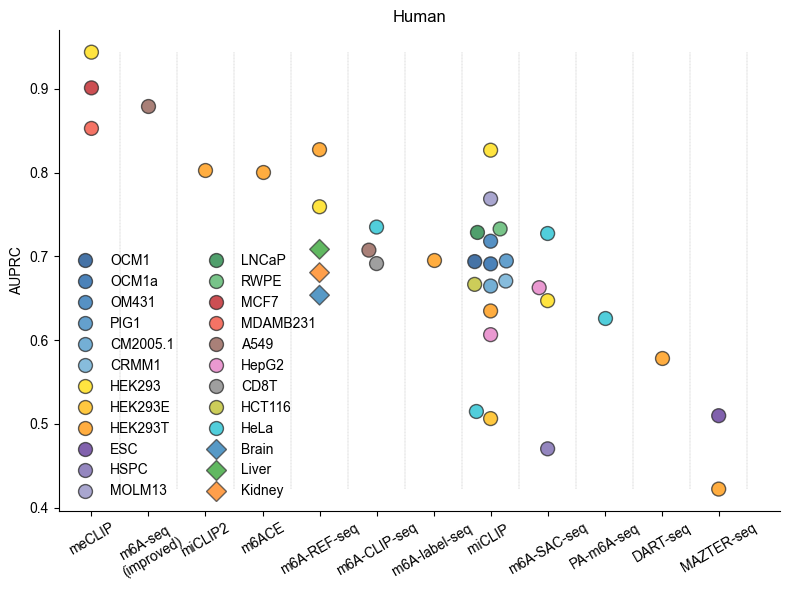

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

order = ['meCLIP', 'm6A-seq\n(improved)', 'miCLIP2', 'm6ACE', 'm6A-REF-seq',
       'm6A-CLIP-seq', 'm6A-label-seq ', 'miCLIP ', 'm6A-SAC-seq',
       'PA-m6A-seq', 'DART-seq', 'MAZTER-seq']
# sns.stripplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, s=10, alpha=.75, palette=dict(cmaps), jitter=.2, linewidth=1, order=order)
# sns.stripplot(df[df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, order=order, s=10, alpha=.75, palette='tab10', jitter=.2, linewidth=1, marker='D')
sns.swarmplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, s=10, alpha=.75, palette=dict(cmaps), linewidth=1, order=order)
sns.swarmplot(df[df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, order=order, s=10, alpha=.75, palette='tab10', linewidth=1, marker='D')

for idx, i in enumerate(order):
    plt.vlines(idx+0.5, df[2].min(), df[2].max(), linestyles='dashed', color='grey', lw=.2)

plt.ylabel('AUPRC')
plt.xlabel('')
plt.xticks(rotation=30)

handles, labels = plt.gca().get_legend_handles_labels()
should = ['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1', 'HEK293', 'HEK293E', 'HEK293T', 'ESC', 'HSPC', 'MOLM13', 'LNCaP', 'RWPE', 'MCF7', 'MDAMB231', 'A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa', 'Brain', 'Liver', 'Kidney']
order = [labels.index(i) for i in should]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', ncol=2, frameon=False)
plt.title('Human')
plt.tight_layout()
plt.savefig('fig/atlas2_human_prc.svg')
plt.show()

In [101]:
_, cls = utils.load('data/m6aatlas/atlas2_mouse.data')
result = utils.load('data/m6aatlas/atlas2_mouse.metrics')

In [102]:
df = []
for name, i in zip(cls, result):
    name = name.split('_')
    # df += [[name[0], name[1], i[-1]['1.0']['precision']]]
    df += [[name[0], name[1], i[2]]]
df = pd.DataFrame(df).replace({'m6A-seq with improved protocol': 'm6A-seq\n(improved)'})
df = df.replace({'Mouse Embryonic Fibroblasts (MEFs)': 'MEFs', 'dorsal root ganglion?(DRG)': 'DRG', 'macrophages': 'Macrophages'})

In [103]:
df.to_csv('fig/atlas2_mouse.csv')

In [104]:
df.groupby(1).agg({2: 'mean'}).sort_values(2).index[::-1]

Index(['m6A-seq2', 'MAZTER-seq', 'miCLIP2', 'm6A-seq\n(improved)', 'miCLIP ',
       'm6A-CLIP-seq', 'm6A-REF-seq'],
      dtype='object', name=1)

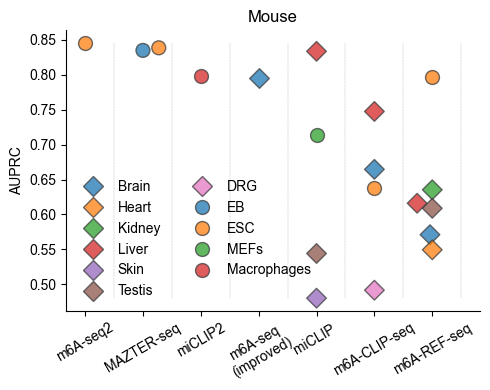

In [105]:
fig = plt.figure(figsize=(5, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

order = ['m6A-seq2', 'MAZTER-seq', 'miCLIP2', 'm6A-seq\n(improved)', 'miCLIP ',
       'm6A-CLIP-seq', 'm6A-REF-seq']
# sns.stripplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis'])], x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', jitter=.1, linewidth=1, order=order)
# sns.stripplot(df[df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis'])], x=1, y=2, hue=0, order=order, s=10, alpha=.75, palette='tab10', jitter=.1, linewidth=1, marker='D')

sns.swarmplot(df[df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis', 'DRG'])], x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', linewidth=1, order=order, marker='D')
sns.swarmplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis', 'DRG'])], x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', linewidth=1, order=order)

for idx, i in enumerate(order):
    plt.vlines(idx+0.5, df[2].min(), df[2].max(), linestyles='dashed', color='grey', lw=.2)
    
plt.ylabel('AUPRC')
plt.xlabel('')
plt.xticks(rotation=30)

# handles, labels = plt.gca().get_legend_handles_labels()
# should = ['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1', 'HEK293', 'HEK293E', 'HEK293T', 'ESC', 'HSPC', 'MOLM13', 'LNCaP', 'RWPE', 'MCF7', 'MDAMB231', 'A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa', 'Brain', 'Liver', 'Kidney']
# order = [labels.index(i) for i in should]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1), loc=2)
# plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(loc='lower left', ncol=2, frameon=False)
plt.title('Mouse')
plt.tight_layout()
plt.savefig('fig/atlas2_mouse_prc.svg')
plt.show()

In [106]:
_, cls = utils.load('data/m6aatlas/atlas2_rat.data')
result = utils.load('data/m6aatlas/atlas2_rat.metrics')

In [107]:
df = []
for name, i in zip(cls, result):
    name = name.split('_')
    # df += [[name[0], name[1], i[-1]['1.0']['precision']]]
    df += [[name[0], name[1], i[2]]]
df = pd.DataFrame(df).replace({'m6A-seq with improved protocol': 'm6A-seq\n(improved)'})
df = df.replace({'Mouse Embryonic Fibroblasts (MEFs)': 'MEFs', 'dorsal root ganglion?(DRG)': 'DRG', 'macrophages': 'Macrophages'})

In [108]:
df.to_csv('fig/atlas2_rat.csv')

In [109]:
df.groupby(1).agg({2: 'mean'}).sort_values(2).index[::-1]

Index(['m6A-REF-seq'], dtype='object', name=1)

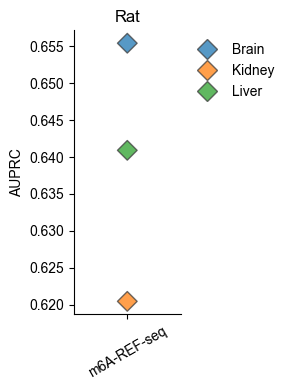

In [110]:
fig = plt.figure(figsize=(3, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

order = ['m6A-REF-seq']
sns.swarmplot(df, x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', linewidth=1, order=order, marker='D')

plt.ylabel('AUPRC')
plt.xlabel('')
plt.xticks(rotation=30)

# handles, labels = plt.gca().get_legend_handles_labels()
# should = ['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1', 'HEK293', 'HEK293E', 'HEK293T', 'ESC', 'HSPC', 'MOLM13', 'LNCaP', 'RWPE', 'MCF7', 'MDAMB231', 'A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa', 'Brain', 'Liver', 'Kidney']
# order = [labels.index(i) for i in should]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1), loc=2)
# plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon=False)
plt.title('Rat')
plt.tight_layout()
plt.savefig('fig/atlas2_rat_prc.svg')
plt.show()

## Performance

In [89]:
_, cls = utils.load('data/m6aatlas/atlas2_human.data')
whistle = utils.load('whistle/model/atlas2.metrics')
whistle = dict(whistle)

In [90]:
result = []
for j in cls:
    key = f'data/{j.replace(' ', '.')}_whistle.bed.hg19.bed.out.csv'
    k = whistle[key]
    j = j.split('_')
    result += [('human', 'WHISTLE', j[0], j[1], k[2])]

for method in ['single', 'dp']:
    for i in ['human', 'mouse', 'rat']:
        _, cls = utils.load(f'data/m6aatlas/atlas2_{i}.data')
        test_res = utils.load(f'model/atlas2_{i}_full_400_ythdf_{method}.metrics')
        for j, k in zip(cls, test_res):
            j = j.split('_')
            result += [(i, method, j[0], j[1], k[2])]

for i in ['human', 'mouse', 'rat']:
    _, cls = utils.load(f'data/m6aatlas/atlas2_{i}.data')
    r = utils.load(f'data/m6aatlas/atlas2_{i}.metrics')
    for j, k in zip(cls, r):
        j = j.split('_')
        result += [(i, 'deepSRAMP', j[0], j[1], k[2])]


In [99]:
pd.DataFrame(result).replace({
    'human': 'Human', 
    'mouse': 'Mouse',
    'rat': 'Rat',
    'dp': 'DeepPromise',
    'single': 'deepSRAMP_single',
}).set_index([0, 2, 3, 1]).unstack()[4][['deepSRAMP', 'deepSRAMP_single', 'WHISTLE', 'DeepPromise']].to_csv('fig/atlas2_performance.csv')